In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [42]:
pd.set_option('display.min_rows', 100)

In [43]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0.1, 0.8, n))

In [53]:
with open("metrics_local_batching_cached_no_cc_64b_12n_4cu_2000si.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={
    "labels.status": "status", 
    "labels.sender": "sender",
    "labels.nonce": "nonce",
    "labels.size": "size",
}, inplace=True)
points["end"] = points['start'] + points['duration']

In [54]:
success = points[points["status"] == "success"].sort_values(by='start')
confirmed = points[points["status"] == "confirmed"].sort_values(by='start')

In [55]:
success.shape

(60, 12)

In [56]:
confirmed.shape

(60, 12)

In [62]:
success["duration"].median()

7258.839109182358

In [63]:
confirmed["duration"].median()

22992.7386200428

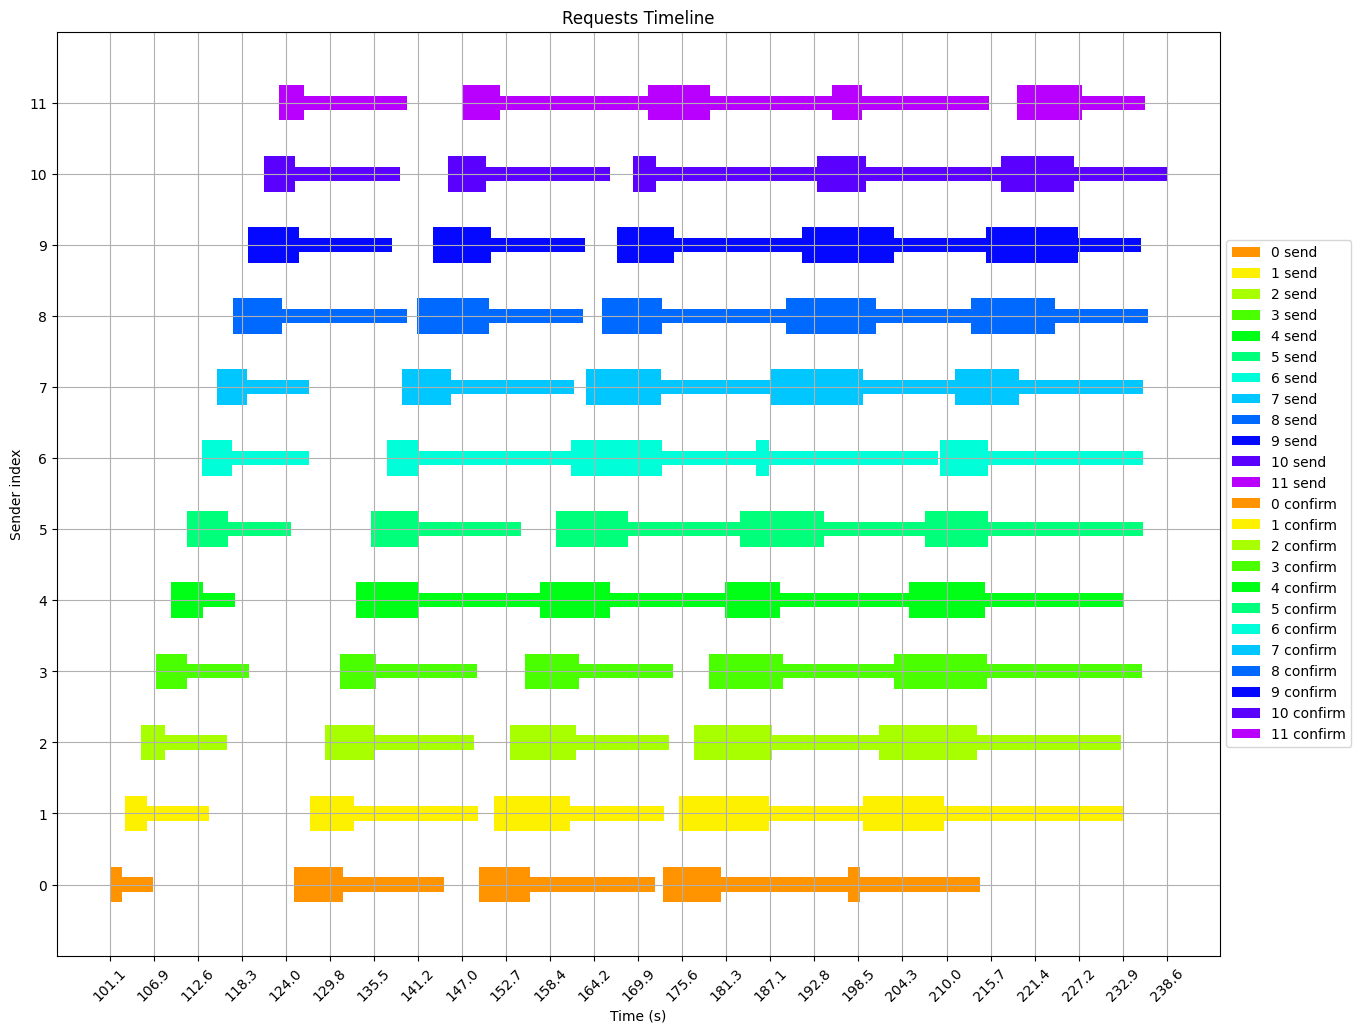

In [61]:
FACTOR = 1e3
count = len(points['sender'].unique())
plt.figure(figsize=(15, count))
cmap = get_cmap(count)

def plot_duration(data, name, th, colors):
    for i, (pnum, group) in enumerate(data.groupby('sender')):
        data = list(zip(group['start'] / FACTOR, group['duration']  / FACTOR))
        label = str(pnum) + " " + name
        color = colors if isinstance(colors, str) else colors[i]
        plt.broken_barh(data, (pnum-th/2, th), facecolor=color, label=label)

plot_duration(success, "send", 0.5, cmap)
plot_duration(confirmed, "confirm", 0.2, cmap)

# Formatting
plt.xticks(np.linspace(confirmed["start"].min() / FACTOR, confirmed["end"].max() / FACTOR, 25), rotation=45)
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (s)')
plt.ylabel('Sender index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

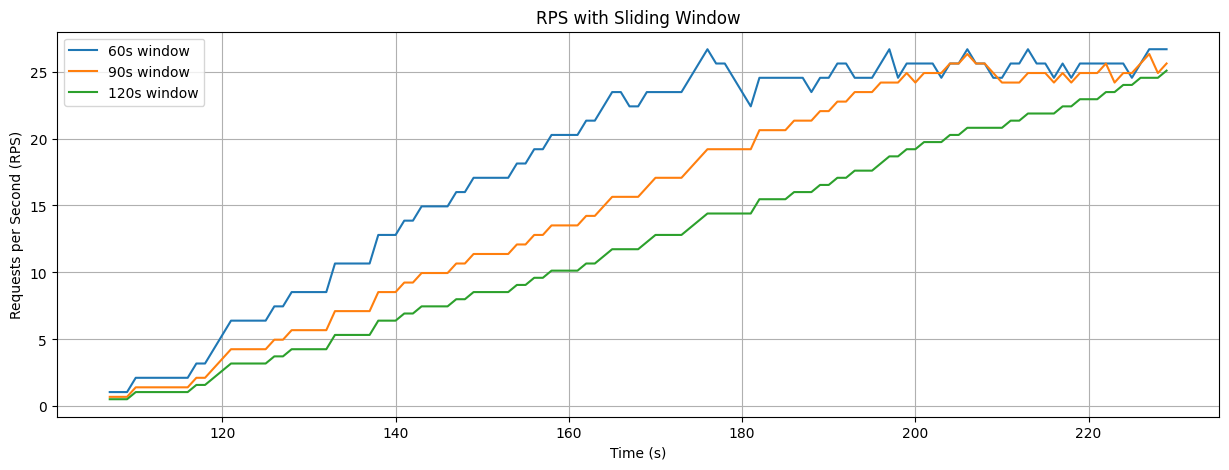

In [51]:
reqs = confirmed[["end", "size"]].copy()
reqs["end"] = pd.to_timedelta(reqs["end"], unit="ms")
reqs = reqs.groupby("end")["size"].sum()

# Resample to 1-second frequency
resampled = reqs.resample('1s').sum()

FACTOR = 1e9
def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index / FACTOR, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(60)
plot_window(90)
plot_window(120)

plt.xlabel('Time (s)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [52]:
confirmed["size"].sum() / (confirmed["end"].max() - confirmed["start"].min()) * 1000

24.023931287053447